In [1]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch.autograd import Function
from torchvision import datasets, models, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit.visualization import *

%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *

# Loading Dataset

In [2]:
X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

idx = []
 
for i in range(5):
    idx.extend(np.where(X_train.targets == i)[0][:])
   
X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

In [3]:
X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = []

for i in range(5):
    idx.extend(np.where(X_test.targets == i)[0][:])
   
X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

## Show Data

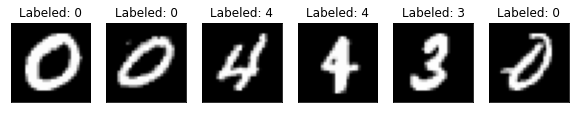

In [4]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))
    
    n_samples_show -= 1

# Setting Quantum Circuit and Hybrid Quantum-Classical Layer

In [5]:
class QuantumCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        job = qiskit.execute(self._circuit, 
                             self.backend, 
                             shots = self.shots,
                             parameter_binds = [{self.theta: theta} for theta in thetas])
        result = job.result().get_counts(self._circuit)
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        
        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)
        
        return np.array([expectation])

In [6]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

# Create Hybrid NN

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 2)
        self.hybrid1 = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)
        self.hybrid2 = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)
        self.fc3 = nn.Linear(2, 5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x1 = self.hybrid1(x[0][0].reshape(1,-1))
        x2 = self.hybrid2(x[0][1].reshape(1,-1))
        x = torch.cat((x1,x2),-1).float()
        x = self.fc3(x)
        return x

# Train and Validation

In [8]:
def train(model, opimizer, loss_func, train_loader):
    model.train()

    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()

        total_loss.append(loss.item())
    #loss_list.append(sum(total_loss)/len(total_loss))

    return sum(total_loss)/len(total_loss)

In [9]:
def validation(model, test_loader):
    model.eval()
    with torch.no_grad():
        total_loss = []
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True) 
            correct += pred.eq(target.view_as(pred)).sum().item()
            loss = loss_func(output, target)
            total_loss.append(loss.item())
    loss = sum(total_loss) / len(total_loss)
    acc = correct / len(test_loader) * 100

    return loss, acc

# Training Network

In [10]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()
train_loss_list = []
test_loss_list = []
acc_list = []
epochs = 40
for epoch in range(epochs):
    train_loss = train(model,optimizer,loss_func,train_loader)
    train_loss_list.append(train_loss)
    test_loss, acc = validation(model,test_loader)
    acc_list.append(acc)
    test_loss_list.append(test_loss) 
    print('Training [{:.0f}%]\ttrain_Loss: {:.4f}\ttest_acc: {:.1f}%'.format(
        100. * (epoch + 1) / epochs, train_loss,acc))

Training [2%]	train_Loss: 0.5258	test_acc: 98.5%
Training [5%]	train_Loss: 0.1646	test_acc: 99.1%
Training [8%]	train_Loss: 0.1132	test_acc: 98.9%
Training [10%]	train_Loss: 0.0939	test_acc: 99.5%
Training [12%]	train_Loss: 0.0797	test_acc: 99.2%
Training [15%]	train_Loss: 0.0790	test_acc: 99.4%
Training [18%]	train_Loss: 0.0735	test_acc: 99.4%
Training [20%]	train_Loss: 0.0733	test_acc: 99.0%
Training [22%]	train_Loss: 0.0717	test_acc: 99.4%
Training [25%]	train_Loss: 0.0726	test_acc: 99.4%
Training [28%]	train_Loss: 0.0663	test_acc: 99.3%
Training [30%]	train_Loss: 0.0675	test_acc: 99.3%
Training [32%]	train_Loss: 0.0680	test_acc: 99.0%
Training [35%]	train_Loss: 0.0687	test_acc: 99.2%
Training [38%]	train_Loss: 0.0681	test_acc: 99.2%
Training [40%]	train_Loss: 0.0642	test_acc: 98.9%
Training [42%]	train_Loss: 0.0673	test_acc: 99.3%
Training [45%]	train_Loss: 0.0676	test_acc: 99.3%
Training [48%]	train_Loss: 0.0652	test_acc: 99.4%
Training [50%]	train_Loss: 0.0626	test_acc: 99.3%
Tra

# Plot Training Graph

Text(0, 0.5, 'Neg Log Likelihood Loss')

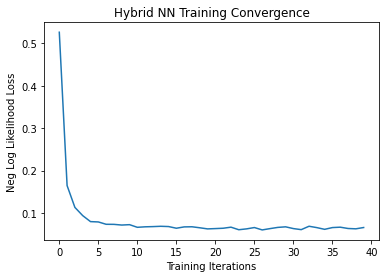

In [11]:
plt.plot(train_loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

# Sigmoid and Tanh

In [12]:
class SNet(nn.Module):
    def __init__(self):
        super(SNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 2)
        self.hybrid1 = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)
        self.hybrid2 = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)
        self.fc3 = nn.Linear(2, 10)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sigmoid(x)
        x = self.fc3(x)
        return x

In [18]:
class TNet(nn.Module):
    def __init__(self):
        super(TNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 2)
        self.hybrid1 = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)
        self.hybrid2 = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)
        self.fc3 = nn.Linear(2, 10)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.tanh(x)
        x = self.fc3(x)
        return x

In [14]:
model = SNet()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()
Strain_loss_list = []
Stest_loss_list = []
Sacc_list = []
epochs = 40
for epoch in range(epochs):
    train_loss = train(model,optimizer,loss_func,train_loader)
    Strain_loss_list.append(train_loss)
    test_loss, acc = validation(model,test_loader)
    Sacc_list.append(acc)
    Stest_loss_list.append(test_loss) 
    print('Training [{:.0f}%]\ttrain_Loss: {:.4f}\ttest_acc: {:.1f}%'.format(
        100. * (epoch + 1) / epochs, train_loss,acc))

Training [2%]	train_Loss: 0.8848	test_acc: 60.1%
Training [5%]	train_Loss: 0.7127	test_acc: 59.9%
Training [8%]	train_Loss: 0.7007	test_acc: 57.2%
Training [10%]	train_Loss: 0.7191	test_acc: 60.5%
Training [12%]	train_Loss: 0.7176	test_acc: 60.0%
Training [15%]	train_Loss: 0.7139	test_acc: 60.8%
Training [18%]	train_Loss: 0.7048	test_acc: 60.6%
Training [20%]	train_Loss: 0.7003	test_acc: 60.6%
Training [22%]	train_Loss: 0.6940	test_acc: 66.5%
Training [25%]	train_Loss: 0.6436	test_acc: 78.1%
Training [28%]	train_Loss: 0.5309	test_acc: 77.9%
Training [30%]	train_Loss: 0.5243	test_acc: 79.1%
Training [32%]	train_Loss: 0.5056	test_acc: 79.0%
Training [35%]	train_Loss: 0.4832	test_acc: 79.1%
Training [38%]	train_Loss: 0.5172	test_acc: 78.7%
Training [40%]	train_Loss: 0.4901	test_acc: 79.4%
Training [42%]	train_Loss: 0.5334	test_acc: 79.0%
Training [45%]	train_Loss: 0.5016	test_acc: 79.0%
Training [48%]	train_Loss: 0.5092	test_acc: 78.9%
Training [50%]	train_Loss: 0.4907	test_acc: 79.5%
Tra

Text(0, 0.5, 'Loss')

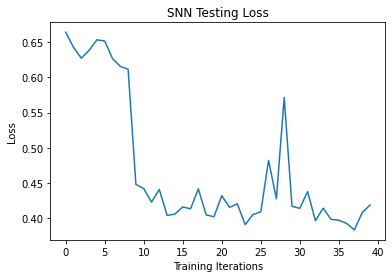

In [15]:
plt.plot(Stest_loss_list)
plt.title('SNN Testing Loss')
plt.xlabel('Training Iterations')
plt.ylabel('Loss')

In [19]:
model = TNet()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()
Ttrain_loss_list = []
Ttest_loss_list = []
Tacc_list = []
epochs = 40
for epoch in range(epochs):
    train_loss = train(model,optimizer,loss_func,train_loader)
    Ttrain_loss_list.append(train_loss)
    test_loss, acc = validation(model,test_loader)
    Tacc_list.append(acc)
    Ttest_loss_list.append(test_loss) 
    print('Training [{:.0f}%]\ttrain_Loss: {:.4f}\ttest_acc: {:.1f}%'.format(
        100. * (epoch + 1) / epochs, train_loss,acc))

Training [2%]	train_Loss: 0.6488	test_acc: 80.1%
Training [5%]	train_Loss: 0.3861	test_acc: 80.2%
Training [8%]	train_Loss: 0.2926	test_acc: 99.3%
Training [10%]	train_Loss: 0.1197	test_acc: 99.3%
Training [12%]	train_Loss: 0.0991	test_acc: 99.1%
Training [15%]	train_Loss: 0.0966	test_acc: 99.4%
Training [18%]	train_Loss: 0.1019	test_acc: 99.5%
Training [20%]	train_Loss: 0.0993	test_acc: 99.6%
Training [22%]	train_Loss: 0.0933	test_acc: 99.6%
Training [25%]	train_Loss: 0.0971	test_acc: 99.4%
Training [28%]	train_Loss: 0.0896	test_acc: 99.4%
Training [30%]	train_Loss: 0.0926	test_acc: 99.6%
Training [32%]	train_Loss: 0.0979	test_acc: 99.6%
Training [35%]	train_Loss: 0.0958	test_acc: 99.3%
Training [38%]	train_Loss: 0.0906	test_acc: 99.3%
Training [40%]	train_Loss: 0.0971	test_acc: 99.7%
Training [42%]	train_Loss: 0.0869	test_acc: 99.3%
Training [45%]	train_Loss: 0.0922	test_acc: 99.4%
Training [48%]	train_Loss: 0.0899	test_acc: 99.6%
Training [50%]	train_Loss: 0.0839	test_acc: 99.5%
Tra

Text(0, 0.5, 'Loss')

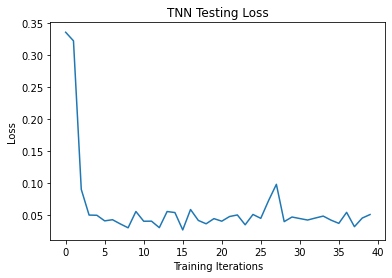

In [20]:
plt.plot(Ttest_loss_list)
plt.title('TNN Testing Loss')
plt.xlabel('Training Iterations')
plt.ylabel('Loss')

Text(0, 0.5, 'Loss')

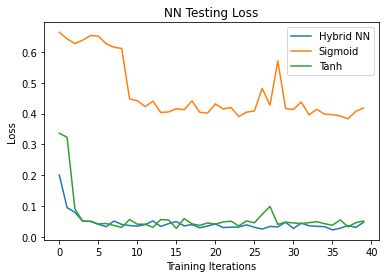

In [21]:
plt.plot(test_loss_list, label='Hybrid NN')
plt.plot(Stest_loss_list, label='Sigmoid')
plt.plot(Ttest_loss_list, label='Tanh')
plt.legend()
plt.title('NN Testing Loss')
plt.xlabel('Training Iterations')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

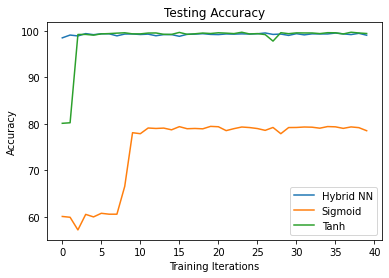

In [22]:
plt.plot(acc_list, label='Hybrid NN')
plt.plot(Sacc_list, label='Sigmoid')
plt.plot(Tacc_list, label='Tanh')
plt.legend()
plt.title('Testing Accuracy')
plt.xlabel('Training Iterations')
plt.ylabel('Accuracy')